In [1]:
from numpy import genfromtxt

train = 'Microsoft-Malware-Challenge/Dataset/train/LargeTrain.csv'
test = 'Microsoft-Malware-Challenge/Dataset/test/LargeTest.csv'


ori_train_data = genfromtxt(train, delimiter=',')
ori_test_data = genfromtxt(test, delimiter=',')

In [2]:
import numpy as np

worst_label_index = 692
row_length = len(ori_train_data[0])

data = np.ndarray(shape=(len(ori_train_data), row_length - 1), dtype=float, order='C')

f_train = []
f_test = []


for i, v in enumerate(ori_train_data):
    if i == 0: continue # skip csv header (list of NaN)
    data[i] = np.delete(v, len(ori_train_data[i]) - 1)
    f_train.append(v[worst_label_index])

for i in ori_test_data:
    f_test.append(i[worst_label_index])

f_train.sort()
f_test.sort()

In [4]:
import xgboost as xgb

labels = np.zeros(len(ori_train_data))

midpoint = len(f_train) / 2

for i in range(len(data)):
    if data[i][worst_label_index] > f_train[midpoint]:
        labels[i] = 1 

dtrain = xgb.DMatrix(data, label=labels)
dtest = xgb.DMatrix(ori_test_data,label=labels)

In [5]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold

skf_inner = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)

xgboost_param = {
    'max_depth':10,
    'min_child_weight':5,
    'learning_rate':0.4,
    'colsample_bytree':0.6,
    'subsample':0.9,
    'gamma':0,
    'max_delta_step':0,
    'colsample_bylevel':1,
    'reg_alpha':0,
    'reg_lambda':1,
    'scale_pos_weight':1,
    'base_score':0.6,
    'random_state':5,
    'objective':'binary:logistic',
    'silent': 1
}

bst_grid = GridSearchCV(estimator=XGBClassifier(**xgboost_param),
                        param_grid={
                            'n_estimators':np.linspace(1, 20, 20).astype('int')
                        }, n_jobs=8, cv=skf_inner, scoring='roc_auc', iid=False,
                        refit=False, verbose=1)

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning) # stop DeprecationWarning
    bst_grid.fit(data, labels)

best_params_grid_search = bst_grid.best_params_
best_score_grid_search = bst_grid.best_score_

COLUMNS = ('mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score')

rows = list(zip(*map(lambda key: bst_grid.cv_results_[key], COLUMNS)))

print(COLUMNS)
for row in rows:
    print(row)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.0s


('mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score')
(0.95799920245493608, 0.012252417168720201, 0.93202598302985606, 0.023303578091377387)
(0.99993365216226737, 3.1767479445436121e-05, 0.99971700985428313, 0.0001740952345672047)
(0.99994481749016584, 3.105063099646885e-05, 0.99972615779830876, 0.00015901444120170412)
(0.99991147975527339, 5.0960205688567171e-05, 0.99956446049826242, 0.00022711505535111481)
(0.99989387351875292, 5.8181837363916763e-05, 0.99945101158613314, 0.00028638991638528993)
(0.99999600599264116, 3.7565574661965068e-06, 0.99992567140239808, 4.819549363334785e-05)
(1.0, 7.0216669371534022e-17, 0.99998826390564177, 1.1951453502109066e-05)
(0.99999975546893727, 3.2604141706471525e-07, 0.99997913583225206, 1.8162764342083207e-05)
(1.0, 4.9650683064945459e-17, 1.0, 0.0)
(1.0, 4.9650683064945459e-17, 1.0, 0.0)
(1.0, 4.9650683064945459e-17, 1.0, 0.0)
(1.0, 0.0, 1.0, 0.0)
(1.0, 0.0, 1.0, 0.0)
(1.0, 0.0, 1.0, 0.0)
(1.0, 0.0, 1.0, 0.0)
(1.0, 4.965068

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.6min finished


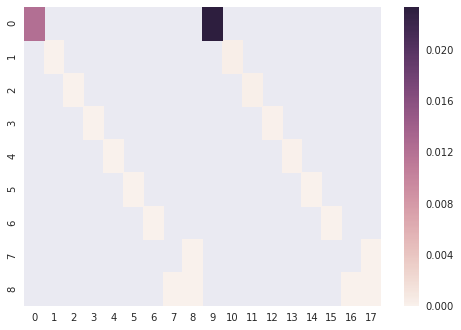

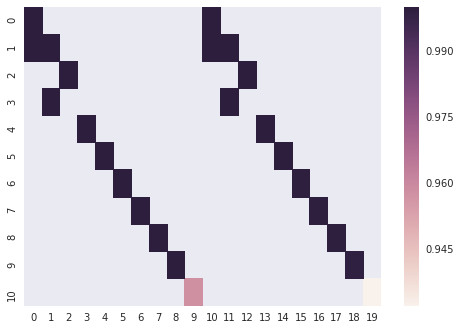

In [15]:
import pandas as pd
import seaborn
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning) # stop DeprecationWarning

    df = pd.DataFrame(rows)
    df.columns = ('test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std')

    source_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-mean'], index=['test-auc-mean'])
    seaborn.heatmap(np.array(source_perf))
    seaborn.plt.show()

    target_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-std'], index=['test-auc-std'])
    seaborn.heatmap(np.array(target_perf))
    seaborn.plt.show()